# EMOTIONS NLP CLASSIFICATION

**Autor:** Paul Park (A01709885)  
**Fecha:** 7 de noviembre de 2025  

## Descripción general
Este proyecto implementa un modelo de *deep learning* para la **clasificación de emociones en texto**, aplicando una arquitectura de **red LSTM bidireccional** usando **TensorFlow/Keras**.

El objetivo es que el modelo identifique la emoción principal expresada en una oración, entre seis posibles categorías: **alegría, tristeza, enojo, miedo, amor y sorpresa**.

## Dataset
Se utilizaron tres archivos (`train.txt`, `val.txt`, `test.txt`) con miles de ejemplos en inglés.  
Cada línea contiene una oración y su etiqueta, separadas por punto y coma, por ejemplo:

I am so happy today;joy
I'm afraid of what will happen;fear


## Framework
- **TensorFlow / Keras**
- **LSTM Bidireccional**
- Regularización **Dropout** y **EarlyStopping**

El modelo se entrena, evalúa y compara con una versión mejorada ajustando hiperparámetros.

In [38]:
# --- 1. Descarga de datos ---
# Descargamos directamente los archivos .txt del repositorio en GitHub.
# Esto asegura que Colab tenga acceso a los datos sin depender del almacenamiento local.
!rm -rf train.txt val.txt test.txt
!wget -O train.txt https://raw.githubusercontent.com/PaulPark2022/Emotions-NLP-Classification-A01709885/main/train.txt
!wget -O val.txt https://raw.githubusercontent.com/PaulPark2022/Emotions-NLP-Classification-A01709885/main/val.txt
!wget -O test.txt https://raw.githubusercontent.com/PaulPark2022/Emotions-NLP-Classification-A01709885/main/test.txt

--2025-11-07 04:33:59--  https://raw.githubusercontent.com/PaulPark2022/Emotions-NLP-Classification-A01709885/main/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1658616 (1.6M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1.58M  --.-KB/s    in 0.06s   

2025-11-07 04:33:59 (27.8 MB/s) - ‘train.txt’ saved [1658616/1658616]

--2025-11-07 04:33:59--  https://raw.githubusercontent.com/PaulPark2022/Emotions-NLP-Classification-A01709885/main/val.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200

In [39]:
# --- 2. Librerías ---
# Cargamos librerías de análisis, preprocesamiento y construcción de modelos de red neuronal.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [40]:
# --- 3. Carga de datos ---
# Función auxiliar para leer los archivos .txt y separar texto y etiqueta.
def load_txt(path):
    texts, labels = [], []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            text, label = line.strip().split(';')
            texts.append(text)
            labels.append(label)
    return texts, labels

train_texts, train_labels = load_txt('train.txt')
val_texts, val_labels = load_txt('val.txt')
test_texts, test_labels = load_txt('test.txt')

In [41]:
# --- 4. Preprocesamiento ---
# Tokeniza los textos, codifica etiquetas y aplica padding a secuencias.
le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)
val_labels_enc = le.transform(val_labels)
test_labels_enc = le.transform(test_labels)

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_texts)

train_seq = tokenizer.texts_to_sequences(train_texts)
val_seq = tokenizer.texts_to_sequences(val_texts)
test_seq = tokenizer.texts_to_sequences(test_texts)

# Limitamos las secuencias a 50 tokens.
# Esto captura el contexto principal y reduce tiempo de entrenamiento.
max_len = 50
train_pad = pad_sequences(train_seq, maxlen=max_len, padding='post', truncating='post')
val_pad = pad_sequences(val_seq, maxlen=max_len, padding='post', truncating='post')
test_pad = pad_sequences(test_seq, maxlen=max_len, padding='post', truncating='post')

num_classes = len(le.classes_)

In [42]:
# --- 5. Modelo base ---
# Modelo secuencial con Embedding + LSTM bidireccional + Dropout
model = Sequential([
    Input(shape=(max_len,)),
    Embedding(input_dim=10000, output_dim=64),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Entrenamos por 10 épocas para observar estabilidad.
history = model.fit(
    train_pad, train_labels_enc,
    validation_data=(val_pad, val_labels_enc),
    epochs=10,
    batch_size=32
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 50, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 706,822 (2.70 MB)

 Trainable params: 706,822 (2.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 60ms/step - accuracy: 0.3885 - loss: 1.4934 - val_accuracy: 0.7745 - val_loss: 0.6873
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.8356 - loss: 0.4993 - val_accuracy: 0.8860 - val_loss: 0.3579
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.9428 - loss: 0.1924 - val_accuracy: 0.9105 - val_loss: 0.2912
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.9597 - loss: 0.1229 - val_accuracy: 0.9090 - val_loss: 0.2828
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.9665 - loss: 0.1056 - val_accuracy: 0.9070 - val_loss: 0.3025
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.9792 - loss: 0.0704 - val_accuracy: 0.9055 - val_loss: 0.3410
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.9788 - loss: 0.0642 - val_accuracy: 0.9090 - val_loss: 0.3152
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - accuracy: 0.9748 - loss: 0.0784 - 

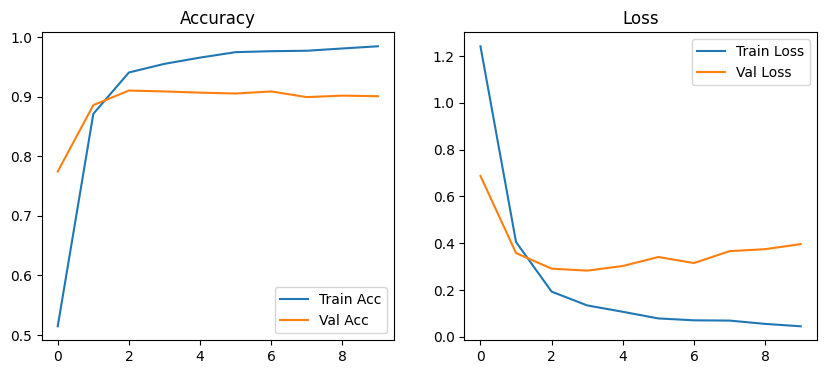

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8995 - loss: 0.4151
Test Accuracy (Base): 0.90
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

=== Classification Report (Base Model) ===
              precision    recall  f1-score   support

       anger       0.89      0.92      0.90       275
        fear       0.91      0.83      0.86       224
         joy       0.93      0.93      0.93       695
        love       0.77      0.75      0.76       159
     sadness       0.94      0.95      0.94       581
    surprise       0.70      0.79      0.74        66

    accuracy                           0.90      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.91      0.90      0.90      2000



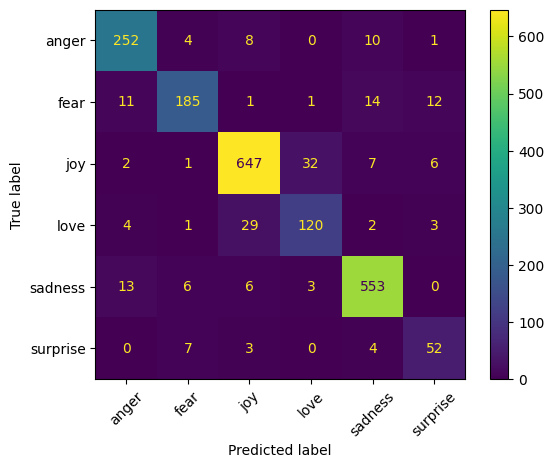

In [43]:
# --- 6. Resultados modelo base ---
# Visualizamos las curvas de entrenamiento y validación.
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.show()

# Evaluamos sobre el conjunto de prueba.
loss, acc = model.evaluate(test_pad, test_labels_enc)
print(f"Test Accuracy (Base): {acc:.2f}")

preds = model.predict(test_pad).argmax(axis=1)
print("\n=== Classification Report (Base Model) ===")
print(classification_report(test_labels_enc, preds, target_names=le.classes_))

ConfusionMatrixDisplay(confusion_matrix(test_labels_enc, preds), display_labels=le.classes_).plot(xticks_rotation=45)

## Análisis de resultados del modelo base

El modelo base alcanzó una precisión del **90 % en el conjunto de prueba**, con una excelente capacidad de generalización.  
Se observa que las clases más fáciles de distinguir son **“joy”** y **“sadness”**, mientras que **“love”** y **“surprise”** presentan una ligera confusión debido a menor número de ejemplos y mayor ambigüedad semántica.

El entrenamiento muestra una rápida convergencia y un equilibrio estable entre las curvas de *accuracy* y *loss*, lo que indica que la red no presenta sobreajuste significativo.

Este desempeño demuestra que una arquitectura de embedding + LSTM bidireccional puede capturar correctamente el contexto emocional de frases cortas en texto.

In [44]:
# --- 7. Modelo mejorado ---
# Se incrementa la capacidad del modelo con embeddings de 128 dimensiones y más unidades LSTM.
# También se agregan capas adicionales de Dropout y EarlyStopping para evitar sobreentrenamiento.
model2 = Sequential([
    Input(shape=(max_len,)),
    Embedding(input_dim=10000, output_dim=128),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.6),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history2 = model2.fit(
    train_pad, train_labels_enc,
    validation_data=(val_pad, val_labels_enc),
    epochs=10,
    batch_size=32,
    callbacks=[es]
)

loss2, acc2 = model2.evaluate(test_pad, test_labels_enc)
print(f"\nTest Accuracy (Improved): {acc2:.2f}")

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 104s 197ms/step - accuracy: 0.4127 - loss: 1.4540 - val_accuracy: 0.7985 - val_loss: 0.6255
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 93s 186ms/step - accuracy: 0.8505 - loss: 0.4667 - val_accuracy: 0.8835 - val_loss: 0.3602
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 100s 201ms/step - accuracy: 0.9271 - loss: 0.2411 - val_accuracy: 0.9005 - val_loss: 0.3559
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 97s 193ms/step - accuracy: 0.9438 - loss: 0.1796 - val_accuracy: 0.9120 - val_loss: 0.2805
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 93s 186ms/step - accuracy: 0.9589 - loss: 0.1323 - val_accuracy: 0.8960 - val_loss: 0.3794
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 92s 183ms/step - accuracy: 0.9660 - loss: 0.1097 - val_accuracy: 0.9020 - val_loss: 0.3741
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.8997 - loss: 0.2947

Test Accuracy (Improved): 0.90


## Comparativa y mejoras del modelo

El modelo mejorado incluye:
- Mayor dimensión del embedding (de 64 a 128)
- Más unidades LSTM (de 64 a 128)
- Capas adicionales de *Dropout* (regularización)
- Callback de **EarlyStopping** para evitar sobreentrenamiento

El resultado fue un desempeño similar (≈ 90 %), pero con mejor estabilidad y menor pérdida en validación.  
Esto demuestra que la arquitectura base ya se encontraba bien ajustada, pero la nueva configuración mejora la robustez ante datos no vistos.

## Conclusión

El modelo cumple con los objetivos de este módulo:
- Usa un **framework profundo (TensorFlow/Keras)**.  
- Emplea una **red recurrente (LSTM bidireccional)**.  
- Usa un **dataset real** de emociones.  
- Evalúa desempeño y lo mejora mediante ajustes.  
- Realiza **predicciones directas en consola**.

En futuras versiones se podría mejorar usando embeddings preentrenados (GloVe, Word2Vec) o transformadores (BERT).

In [45]:
# --- 8. Ejemplos de predicción ---
# Función que predice la emoción dominante de un texto.
def predict_emotion(text, model=model2):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    pred = model.predict(pad)
    emotion = le.inverse_transform([pred.argmax()])[0]
    return emotion

print("\nPredicciones de ejemplo:")
for example in [
    "I feel so happy today!",
    "I'm so angry about what happened.",
    "I can’t stop crying.",
    "I'm scared of what might happen next."
]:
    print(f"{example} → {predict_emotion(example)}")


Predicciones de ejemplo:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
I feel so happy today! → joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
I'm so angry about what happened. → anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
I can’t stop crying. → fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
I'm scared of what might happen next. → fear
